# 项目背景

业务部门希望数据部门能对流失用户做分析，找到流失用户的典型特征，例如，到底流失客户的哪些特性最显著，当客户在哪些特征的什么条件下比较容易发生流失行为，并给到业务部门。这样业务部门就能针对这些客户的典型特征做有针对性的业务优化及挽回动作。

基于上述场景和需求，本次分析的交付需求如下：
- 关于特征提取的分析工作，目标交付物是特征重要性和特征规则。
- 该需求可通过决策树类的分类算法实现，并且决策树是最好的解释规则的算法。
- 业务部门需要了解规则的关系，那么必须提供规则图。
- 数据集大概率会出现样本不均衡问题，原因是**流失用户一定是少量的**。

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score,recall_score, roc_curve #导入指标库
import prettytable                            #导入表格库
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE      #过抽样处理库

In [2]:
raw_data = pd.read_csv('classification.csv', delimiter=',') #读取数据文件
X,y = raw_data.iloc[:, :-1], raw_data.iloc[:, -1]           #分割x,y

In [3]:
n_samples, n_features = X.shape #总样本量，总样本数
print('samples: {0} | features: {1} | na count: {2}'.format(n_samples, n_features, raw_data.isnull().any().count()))

samples: 1000 | features: 41 | na count: 42


In [4]:
#数据预处理:填充缺失值和样本均衡
X = X.fillna(X.mean())

model_smote = SMOTE()
X, y = model_smote.fit_sample(X,y)

In [5]:
#拆分数据集
X = pd.DataFrame(X, columns=raw_data.columns[:-1])
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
#XGB分类模型训练
param_dist = {'objective': 'binary:logistic', 'n_estimators':10, 'subsample':0.8, 'max_depth':10, 'n_jobs':-1}
model_xgb = xgb.XGBClassifier(**param_dist)
model_xgb.fit(X_train, y_train)
pre_y = model_xgb.predict(X_test)

In [7]:
#模型效果评估-混淆矩阵
tn, fp, fn, tp = confusion_matrix(y_test, pre_y).ravel()        #获得混淆矩阵
print(confusion_matrix(y_test, pre_y).ravel())
confusion_matrix_table = prettytable.PrettyTable(['', 'prediction-0', 'prediction-1']) #创建表格实例
confusion_matrix_table.add_row(['actual-0', tp, fn])            #增加第一行数据
confusion_matrix_table.add_row(['actual-1', fp, tn])            #增加第二行数据
print('confusion matrix \n', confusion_matrix_table)

[173  49  28 186]
confusion matrix 
 +----------+--------------+--------------+
|          | prediction-0 | prediction-1 |
+----------+--------------+--------------+
| actual-0 |     186      |      28      |
| actual-1 |      49      |     173      |
+----------+--------------+--------------+


In [8]:
#核心评估指标
y_score = model_xgb.predict_proba(X_test)          #获得决策树的预测概率
fpr, tpr, _ =roc_curve(y_test, y_score[:, -1])     #ROC
auc_s = auc(fpr, tpr)                              #AUC
scores = [round(i(y_test,pre_y), 3)for i in (accuracy_score, precision_score, recall_score, f1_score)]
scores.insert(0, auc_s)

core_metrics = prettytable.PrettyTable()
core_metrics.field_names = ['auc', 'accuracy', 'precision', 'recall', 'f1']  #定义表格列名
core_metrics.add_row(scores)                       #增加数据
print('core metrics\n', core_metrics)

core metrics
 +--------------------+----------+-----------+--------+-------+
|        auc         | accuracy | precision | recall |   f1  |
+--------------------+----------+-----------+--------+-------+
| 0.9044371474278016 |  0.823   |   0.791   | 0.869  | 0.829 |
+--------------------+----------+-----------+--------+-------+


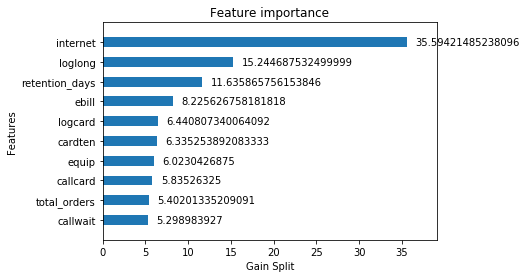

In [9]:
#特征重要性
xgb.plot_importance(model_xgb, height=0.5, importance_type='gain', max_num_features=10,xlabel='Gain Split', grid=False)

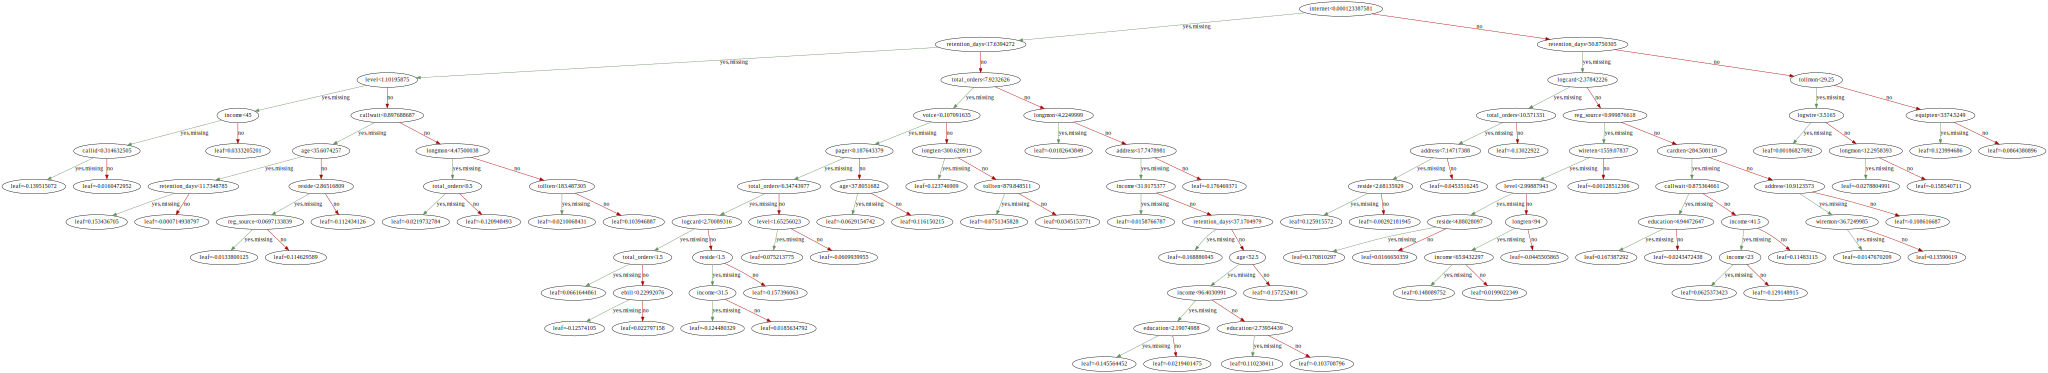

In [10]:
# 输出树形规则图
xgb.to_graphviz(model_xgb, num_trees=1, yes_color='#638e5e', no_color='#a40000')

In [12]:
# 前N条规则对应的用户数据
rule_depth_1 = X_test['internet']<0.000123387581
rule_depth_2 = X_test['retention_days']<17.6394272
rule_depth_3 = X_test['level']<1.10195875
rule_depth_4 = X_test['income']<45
rule_depth_5 = X_test['callid']<0.314632505
rule_list = [rule_depth_1,rule_depth_2,rule_depth_3,rule_depth_4,rule_depth_5]
rule_pd = [pd.DataFrame(i) for i in rule_list]
rule_pd_merge = pd.concat(rule_pd,axis=1)
print(rule_pd_merge.head())
print("-"*60)

# 遍历不同条件下用户的情况
for i in range(5):
    dyn_rules = rule_pd_merge.iloc[:,:i+1] # 取出top规则
    print(dyn_rules.head(8))
    dyn_rules['is_true']=[all(j)==True for j in dyn_rules.values]# 得到都为true的record
    y_test_selected = y_test[dyn_rules['is_true']]
    y_pre_selected = y_score[dyn_rules['is_true']]
    y_pre_cal = y_pre_selected[:,1] >= 0.5
    total_samples = len(y_pre_cal)
    is_churn = y_pre_cal.sum()
    churn_rate = float(is_churn)/total_samples
    # 计算样本比例
    print('total samples: {}'.format(total_samples))
    print('churn samples: {} | rate: {:.0%} '.format(is_churn,churn_rate))
    print('unchurn samples: {} | rate: {:.0%} '.format((total_samples-is_churn),(1-churn_rate)))
    print('-'*40)

      internet  retention_days  level  income  callid
1370      True            True   True   False    True
482      False            True  False   False    True
1292     False           False  False    True    True
270       True           False  False    True   False
278       True           False  False    True    True
------------------------------------------------------------
      internet
1370      True
482      False
1292     False
270       True
278       True
665       True
1011     False
1165     False
total samples: 218
churn samples: 53 | rate: 24% 
unchurn samples: 165 | rate: 76% 
----------------------------------------
      internet  retention_days
1370      True            True
482      False            True
1292     False           False
270       True           False
278       True           False
665       True           False
1011     False            True
1165     False           False
total samples: 59
churn samples: 34 | rate: 58% 
unchurn samples: 25 | rate:

C:\Users\teamo\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 结论：

从结果来看，随着条件的增加，流失用户的概率越来越高。当规则越多时，覆盖的样本量和流失用户的数量越少。

交付结果：
需要让业务人员综合样本量以及流失用户的概率综合判断，如果条件过多，虽然选择的用户越精准，但却会无法覆盖更多的可能用户。如果条件太少，又会导致用户泛泛，也无法达到精准的目的。最终业务房可直接在数据库中，通过SQL检索查询符合要求的客户，然后做有针对性的运营工作。